In [7]:
# Importing the libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf

from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, Dropout, GRU, Bidirectional
from tensorflow.keras.optimizers import SGD
from tensorflow.random import set_seed



đọc file dữ liệu

In [12]:
set_seed(455)
np.random.seed(455)

dataset = pd.read_csv(
    "Mastercard_stock_history.csv", index_col="Date", parse_dates=["Date"]
).drop(["Dividends", "Stock Splits"], axis=1)
print(dataset.head())
print(dataset.describe())
dataset.isna().sum()

                Open      High       Low     Close       Volume
Date                                                           
2006-05-25  3.748967  4.283869  3.739664  4.279217  395343000.0
2006-05-26  4.307126  4.348058  4.103398  4.179680  103044000.0
2006-05-30  4.183400  4.184330  3.986184  4.093164   49898000.0
2006-05-31  4.125723  4.219679  4.125723  4.180608   30002000.0
2006-06-01  4.179678  4.474572  4.176887  4.419686   62344000.0
              Open         High          Low        Close        Volume
count  3872.000000  3872.000000  3871.000000  3871.000000  3.871000e+03
mean    104.806794   105.863622   103.705998   104.818383  1.232486e+07
std     106.186281   107.240636   104.989637   106.106905  1.759832e+07
min       0.440000     0.000000     3.739664     4.083861  6.411000e+05
25%      22.317735    22.607756    22.033986    22.300154  3.530350e+06
50%      70.810070    71.363565    70.206683    70.848236  5.895000e+06
75%     147.514671   148.400641   146.760831   1

Open      0
High      0
Low       1
Close     1
Volume    1
dtype: int64

mô phỏng dữ liệu

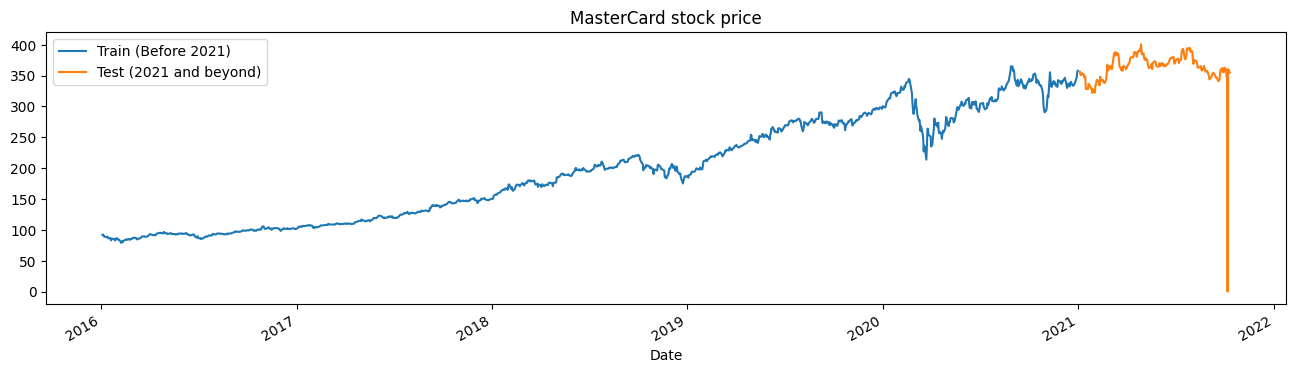

In [13]:
tstart = 2016
tend = 2020


def train_test_plot(dataset, tstart, tend):
    dataset.loc[f"{tstart}":f"{tend}", "High"].plot(figsize=(16, 4), legend=True)
    dataset.loc[f"{tend + 1}":, "High"].plot(figsize=(16, 4), legend=True)
    plt.legend([f"Train (Before {tend + 1})", f"Test ({tend + 1} and beyond)"])
    plt.title("MasterCard stock price")
    plt.show()


train_test_plot(dataset, tstart, tend)

chia dữ liệu thành hai phần: train và test

In [ ]:
def train_test_split(dataset, tstart, tend):
    train = dataset.loc[f"{tstart}":f"{tend}", "High"].values
    test = dataset.loc[f"{tend + 1}":, "High"].values
    return train, test


training_set, test_set = train_test_split(dataset, tstart, tend)

sc = MinMaxScaler(feature_range=(0, 1))
training_set = training_set.reshape(-1, 1)
training_set_scaled = sc.fit_transform(training_set)

tạo hàm để chuyển thành input

In [16]:
def split_sequence(sequence, n_steps):
    X, y = list(), list()
    for i in range(len(sequence)):
        end_ix = i + n_steps
        if end_ix > len(sequence) - 1:
            break
        seq_x, seq_y = sequence[i:end_ix], sequence[end_ix]
        X.append(seq_x)
        y.append(seq_y)
    return np.array(X), np.array(y)


n_steps = 60
features = 1
# split into samples
X_train, y_train = split_sequence(training_set_scaled, n_steps)

# Reshaping X_train for model
X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], features)

NameError: name 'training_set_scaled' is not defined

hàm mô hình hóa dữ liệu và tính toán giá trị RMSE ( độ lệch chuẩn )

In [ ]:
def plot_predictions(test, predicted):
    plt.plot(test, color="gray", label="Real")
    plt.plot(predicted, color="red", label="Predicted")
    plt.title("MasterCard Stock Price Prediction")
    plt.xlabel("Time")
    plt.ylabel("MasterCard Stock Price")
    plt.legend()
    plt.show()


def return_rmse(test, predicted):
    rmse = np.sqrt(mean_squared_error(test, predicted))
    print("The root mean squared error is {:.2f}.".format(rmse))

xử lý dữ liệu

In [ ]:
dataset_total = dataset.loc[:, "High"]
inputs = dataset_total[len(dataset_total) - len(test_set) - n_steps:].values
inputs = inputs.reshape(-1, 1)
# scaling
inputs = sc.transform(inputs)

# Split into samples
X_test, y_test = split_sequence(inputs, n_steps)
# reshape
X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], features)

sử dụng mô hình LSTM

In [ ]:
# The LSTM architecture
model_lstm = Sequential()
model_lstm.add(LSTM(units=125, activation="tanh", input_shape=(n_steps, features)))
model_lstm.add(Dense(units=1))
# Compiling the model
model_lstm.compile(optimizer="RMSprop", loss="mse")

model_lstm.summary()
model_lstm.fit(X_train, y_train, epochs=50, batch_size=32)

# prediction
predicted_stock_price = model_lstm.predict(X_test)
# inverse transform the values
predicted_stock_price = sc.inverse_transform(predicted_stock_price)



plot_predictions(test_set, predicted_stock_price)
return_rmse(test_set, predicted_stock_price)


sử dụng mô hình GRU

In [15]:
model_gru = Sequential()
model_gru.add(GRU(units=125, activation="tanh", input_shape=(n_steps, features)))
model_gru.add(Dense(units=1))
# Compiling the RNN
model_gru.compile(optimizer="RMSprop", loss="mse")

model_gru.summary()
model_gru.fit(X_train, y_train, epochs=50, batch_size=32)

GRU_predicted_stock_price = model_gru.predict(X_test)
GRU_predicted_stock_price = sc.inverse_transform(GRU_predicted_stock_price)

plot_predictions(test_set, GRU_predicted_stock_price)
return_rmse(test_set, GRU_predicted_stock_price)

NameError: name 'n_steps' is not defined